# UAV Mission Planning

This notebook illustrates the process of planning a UAV mission using Python GIS tools.  The mission is required to respect minimum distances from hazards such as roads and railways.  Given a set of waypoints and a target operating area, the planning process identifies safe zones, no-fly zones, control zones (where entry is subject to clearance from observers) and intermediate waypoints.

Source: https://automating-gis-processes.github.io/CSC/index.html

## Dependencies

Python packages shapely, geopandas, matplotlib and pymavlink are required, and of course the Jupyter notebook.  One of their dependencies doesn't seem to install: descartes.  Command `pip install geopandas pymavlink jupyter matplotlib descartes` should do the trick.

## Importing map data

The process begins by importing a basic map and plotting it.  The example data files are sourced from OpenStreetMap and they're pretty big, so expect a little delay from the `read_file` commands.

Note that the `%matplotlib` magic means that the plots are interactive, so you can hover over them and read coordinates.

## THIS DOES NOT IMPLY PERMISSION TO FLY

Use of this planning tool does not imply permission to fly in the location of the example.  The landowner's permission is required.  See the [Drone Code](https://dronesafe.uk/drone-code/) for more information.  Fly safe!

## Citing this work

If you use this software, please cite its original source:

H. Goudarzi, D. Hine and A. Richards, "Mission Automation for Drone Inspection in Congested Environments," 2019 Workshop on Research, Education and Development of Unmanned Aerial Systems (RED UAS), Cranfield, United Kingdom, 2019, pp. 305-314.

DOI: [10.1109/REDUAS47371.2019.8999719](https://doi.org/10.1109/REDUAS47371.2019.8999719)

<IPython.core.display.Javascript object>


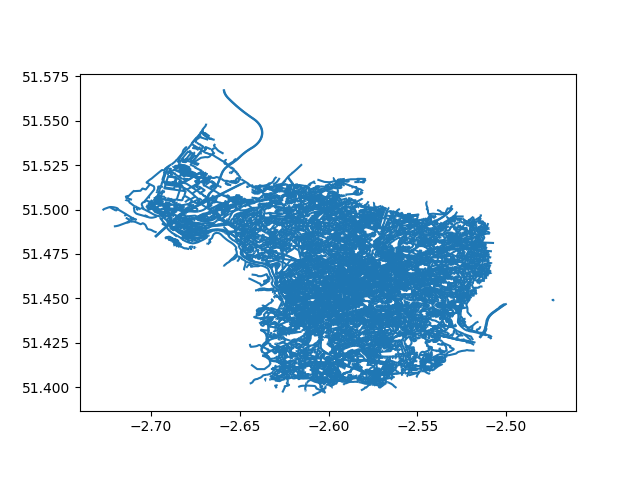

,osm_id,code,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel,geometry
0,3391098,5111,motorway,None,M49,F,112,0,F,F,"LINESTRING (-2.66675 51.50947, -2.66618 51.510..."
1,3391104,5111,motorway,None,M49,F,112,0,F,F,"LINESTRING (-2.66786 51.50466, -2.66794 51.502..."
2,3391107,5111,motorway,None,M5,F,112,0,F,F,"LINESTRING (-2.68481 51.49633, -2.68420 51.49676)"
3,3391109,5111,motorway,None,M49,F,112,0,F,F,"LINESTRING (-2.67498 51.50161, -2.67028 51.504..."
4,3444375,5113,primary,Lawrence Hill Roundabout,A420,F,48,0,F,F,"LINESTRING (-2.56996 51.45889, -2.56983 51.458..."


In [1]:
import geopandas as gpd
roads = gpd.read_file('data/bristol-latest-free.shp/gis_osm_roads_free_1.shp')
%matplotlib notebook
roads.plot()
roads.head()

The first map loaded just shows roads.  The next two maps add two different types of hazards: railways and buildings.

> Note that the roads file from OpenStreetMap includes footpaths.

<IPython.core.display.Javascript object>


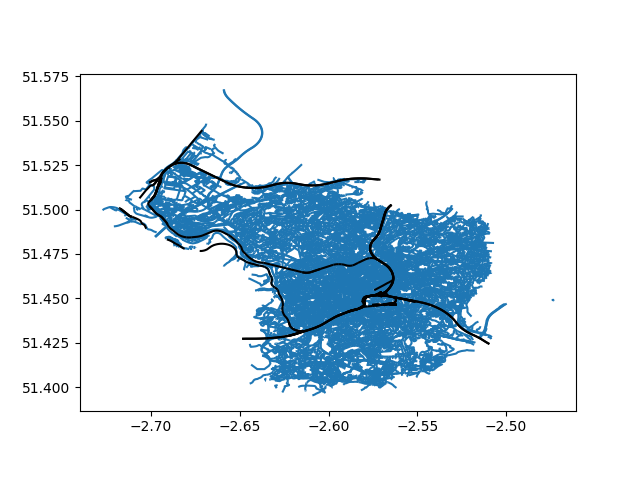

,osm_id,code,fclass,name,geometry
0,3444754,6101,rail,Great Western Main Line,"LINESTRING (-2.54073 51.44556, -2.53961 51.445..."
1,3994992,6101,rail,None,"LINESTRING (-2.70077 51.50453, -2.70049 51.504..."
2,3994993,6101,rail,None,"LINESTRING (-2.59276 51.51649, -2.59118 51.516..."
3,4015973,6101,rail,Bristol to Taunton Line,"LINESTRING (-2.58450 51.44373, -2.58405 51.443..."
4,4082932,6101,rail,None,"LINESTRING (-2.56709 51.45421, -2.56728 51.45401)"


In [2]:
rails = gpd.read_file('data/bristol-latest-free.shp/gis_osm_railways_free_1.shp')
ax=roads.plot()
rails.plot(ax=ax,color='black')
rails.head()

<IPython.core.display.Javascript object>


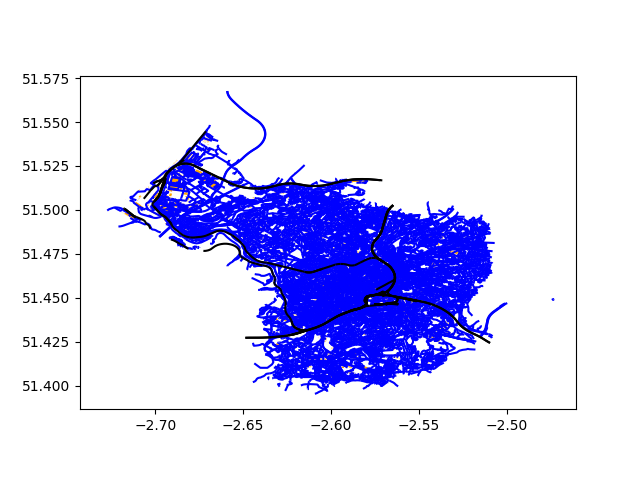

,osm_id,code,fclass,name,type,geometry
0,4309554,1500,building,Bristol City Hall,None,"POLYGON ((-2.60238 51.45240, -2.60213 51.45284..."
1,4315318,1500,building,Clifton Cathedral,church,"POLYGON ((-2.61673 51.45965, -2.61673 51.45965..."
2,4315809,1500,building,Clifton Down Shopping Centre,retail,"POLYGON ((-2.61133 51.46431, -2.61070 51.46441..."
3,4317900,1500,building,Za Za Bazaar,None,"POLYGON ((-2.59869 51.45029, -2.59865 51.45042..."
4,4317901,1500,building,Mackenzies Café Bar,commercial,"POLYGON ((-2.59851 51.45107, -2.59850 51.45110..."


In [3]:
urban = gpd.read_file('data/bristol-latest-free.shp/gis_osm_buildings_a_free_1.shp')
ax=urban.plot(color='orange')
roads.plot(ax=ax,color='blue')
rails.plot(ax=ax,color='black')
urban.head()

## Waypoints

Our basic data map is hardly pretty, but there's enough visible on it to navigate, so you can use the zoom command and mouse hover to identify the waypoint locations.  These then get typed in below, and plotted on our map (you may need to zoom in to see them).

By convention, the first waypoint (location 0 in the data frame) is the home location.  We'll use this later to define the flight path.  Also by convention, the `Name` field gives each waypoint a simple five-character phonetic name for easy identification.

> You could use algorithmic means to define your waypoints, e.g. spread them out along a line.  Here, theyr're just manually entered. 

<IPython.core.display.Javascript object>


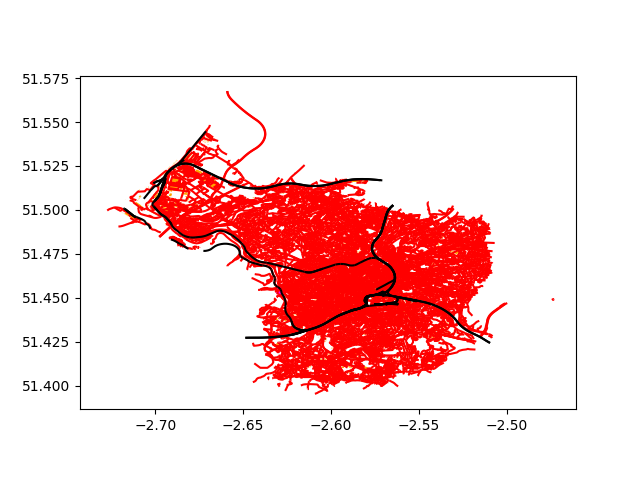

,geometry,Name
0,POINT (-2.62914 51.45455),HOMER
1,POINT (-2.62778 51.45505),ALPHA
2,POINT (-2.62801 51.45499),BRAVO
3,POINT (-2.62831 51.45487),CHALI


In [4]:
from shapely.geometry import Point
wypts = gpd.GeoDataFrame()
wypts['geometry'] = None
home_point = Point(-2.629137,51.454551)
wypts.loc[0, 'geometry'] = home_point
wypts.loc[0, 'Name'] = 'HOMER'
wypts.loc[1, 'geometry'] = Point(-2.627776,51.455053)
wypts.loc[1, 'Name'] = 'ALPHA'
wypts.loc[2, 'geometry'] = Point(-2.628010,51.454990)
wypts.loc[2, 'Name'] = 'BRAVO'
wypts.loc[3, 'geometry'] = Point(-2.628306,51.454870)
wypts.loc[3, 'Name'] = 'CHALI'

ax=urban.plot(color='orange')
roads.plot(ax=ax,color='red')
rails.plot(ax=ax,color='black')
wypts.plot(ax=ax,color='magenta')

wypts

## Flight Region

We also define a flight region that contains the waypoints and that represents the outer boundary of where we plan to fly.  This can be done manually, by identifying points of a polygon from the map, or by constructing a region using the waypoints. 

<IPython.core.display.Javascript object>


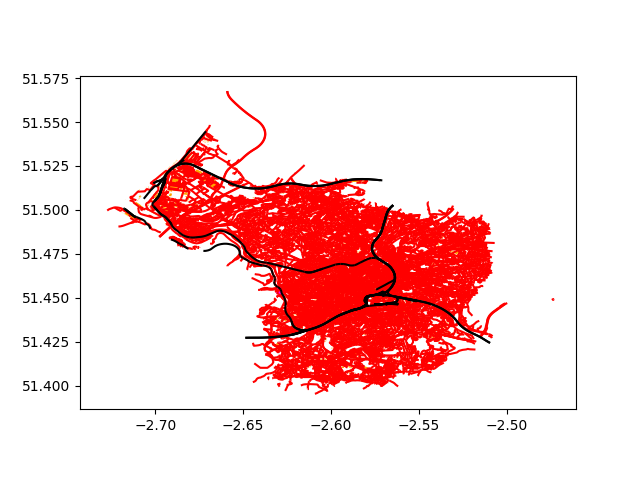

,geometry
0,"POLYGON ((-2.62959 51.45455, -2.62959 51.45505..."


In [5]:
# will need to convert metres to degrees of lat/lon
from math import radians,cos
metres_to_deglatlon = 1./(110*1000*cos(radians(home_point.y)))
metres_to_deglatlon = 1./(110*1000)

# could set the flight region manually...
from shapely.geometry import Polygon
#flight_poly = Polygon([[356323,173097],[356450,173162],[356494,173083],[356375,173004]])

# or set it using a buffer zone round the waypoints
from shapely.geometry import MultiPoint
flight_poly = MultiPoint(wypts.geometry).envelope.buffer(50*metres_to_deglatlon)
#flight_poly = MultiPoint(wypts.geometry).convex_hull.buffer(10)

# put the flight area in a data frame
flight_region = gpd.GeoDataFrame()
flight_region['geometry'] = None
flight_region.loc[0, 'geometry'] = flight_poly

ax=urban.plot(color='orange')
roads.plot(ax=ax,color='red')
rails.plot(ax=ax,color='black')
flight_region.plot(ax=ax,color='cyan')
wypts.plot(ax=ax,color='magenta')

flight_region

## Identifying hazards

We need to identify regions close to the hazards, such as the roads and railways.  Since our hazard maps are large, we first identify those hazards that get sufficiently close to the flight region.  

First, we define a safety distance called `buffer_radius` representing how far away we need to stay.  Here I'm using the standard 50m.  Then, we enlarge the flight region by the same amount, as any hazard that enters this enlarged region is close enough for us to worry about.

<IPython.core.display.Javascript object>


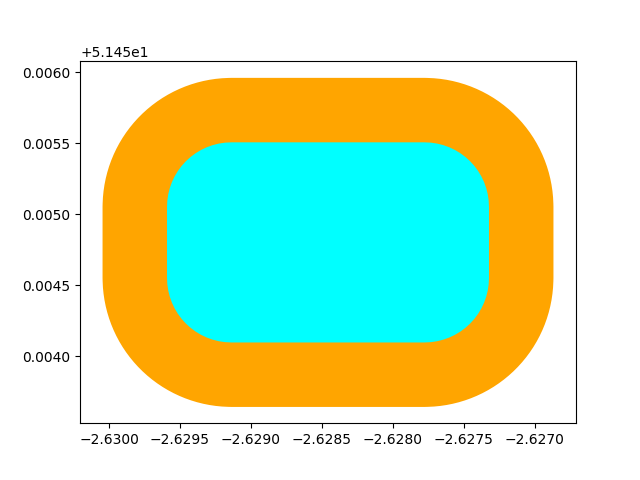

In [6]:
buffer_radius = 50*metres_to_deglatlon
hazard_region = flight_region.set_geometry(flight_region.buffer(buffer_radius))
hazard_poly = hazard_region.loc[0,'geometry']

# start an empty data frame to collect all relevant hazard items
hazards = gpd.GeoDataFrame(geometry=[])

ax=hazard_region.plot(color='orange')
flight_region.plot(ax=ax,color='cyan')

Hazards are added by filtering iems from the road, rail and urban extent maps that intersect with our enlarged region of interest.  This is the same process, iterated three times over the different map data frames.

<IPython.core.display.Javascript object>


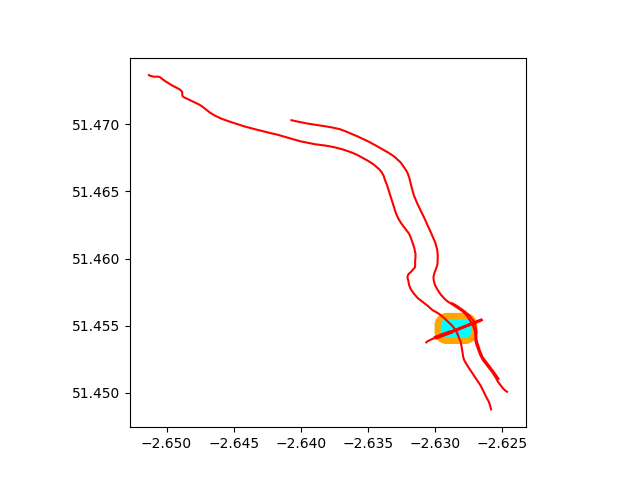

,geometry,osm_id,code,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel
124,"LINESTRING (-2.62890 51.45450, -2.62647 51.45547)",3578235,5114.0,secondary,Clifton Suspension Bridge,B3129,B,32.0,1.0,T,F
184,"LINESTRING (-2.62698 51.45493, -2.62696 51.454...",4002665,5112.0,trunk,Hotwell Road,A4,B,64.0,0.0,F,F
185,"LINESTRING (-2.62738 51.45566, -2.62713 51.455...",4002666,5112.0,trunk,Avon Gorge Gallery,A4,B,64.0,0.0,F,T
7426,"LINESTRING (-2.62886 51.45456, -2.62652 51.45549)",84470379,5153.0,footway,None,None,B,0.0,1.0,T,F
10103,"LINESTRING (-2.62766 51.45594, -2.62750 51.455...",133638236,5112.0,trunk,Hotwell Road,A4,B,64.0,0.0,F,F
10105,"LINESTRING (-2.62880 51.45672, -2.62841 51.456...",133638239,5112.0,trunk,Hotwell Road,A4,B,64.0,0.0,F,F
10222,"LINESTRING (-2.64078 51.47032, -2.64018 51.470...",144776655,5152.0,cycleway,Portway,None,B,0.0,0.0,F,F
10964,"LINESTRING (-2.63070 51.45370, -2.63064 51.453...",158410884,5114.0,secondary,None,B3129,B,32.0,0.0,F,F
13857,"LINESTRING (-2.65137 51.47371, -2.65125 51.473...",232628450,5152.0,cycleway,None,None,B,0.0,0.0,F,F
16597,"LINESTRING (-2.62905 51.45444, -2.62903 51.45445)",377184272,5114.0,secondary,None,B3129,B,32.0,0.0,F,F


In [7]:
this_layer = roads

hazards = hazards.append(this_layer[this_layer.geometry.intersects(hazard_poly)], sort=False)

ax=hazard_region.plot(color='orange')
flight_region.plot(ax=ax,color='cyan')
hazards.plot(ax=ax,color='red')
hazards

<IPython.core.display.Javascript object>


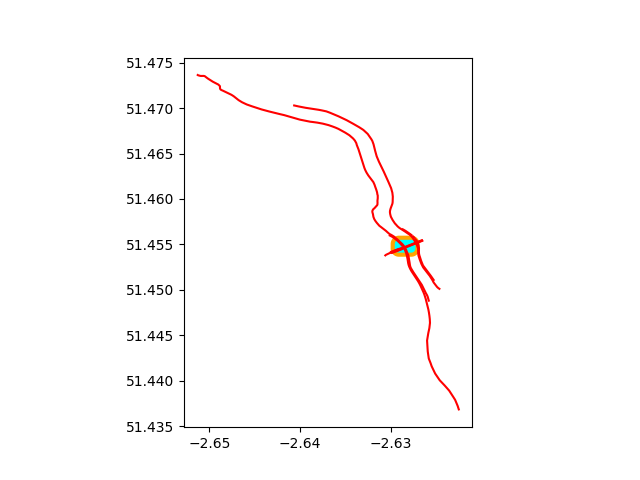

,geometry,osm_id,code,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel
124,"LINESTRING (-2.62890 51.45450, -2.62647 51.45547)",3578235,5114.0,secondary,Clifton Suspension Bridge,B3129,B,32.0,1.0,T,F
184,"LINESTRING (-2.62698 51.45493, -2.62696 51.454...",4002665,5112.0,trunk,Hotwell Road,A4,B,64.0,0.0,F,F
185,"LINESTRING (-2.62738 51.45566, -2.62713 51.455...",4002666,5112.0,trunk,Avon Gorge Gallery,A4,B,64.0,0.0,F,T
7426,"LINESTRING (-2.62886 51.45456, -2.62652 51.45549)",84470379,5153.0,footway,None,None,B,0.0,1.0,T,F
10103,"LINESTRING (-2.62766 51.45594, -2.62750 51.455...",133638236,5112.0,trunk,Hotwell Road,A4,B,64.0,0.0,F,F
10105,"LINESTRING (-2.62880 51.45672, -2.62841 51.456...",133638239,5112.0,trunk,Hotwell Road,A4,B,64.0,0.0,F,F
10222,"LINESTRING (-2.64078 51.47032, -2.64018 51.470...",144776655,5152.0,cycleway,Portway,None,B,0.0,0.0,F,F
10964,"LINESTRING (-2.63070 51.45370, -2.63064 51.453...",158410884,5114.0,secondary,None,B3129,B,32.0,0.0,F,F
13857,"LINESTRING (-2.65137 51.47371, -2.65125 51.473...",232628450,5152.0,cycleway,None,None,B,0.0,0.0,F,F
16597,"LINESTRING (-2.62905 51.45444, -2.62903 51.45445)",377184272,5114.0,secondary,None,B3129,B,32.0,0.0,F,F


In [8]:
this_layer = rails

hazards = hazards.append(this_layer[this_layer.geometry.intersects(hazard_poly)], sort=False)

ax=hazard_region.plot(color='orange')
flight_region.plot(ax=ax,color='cyan')
hazards.plot(ax=ax,color='red')
hazards

<IPython.core.display.Javascript object>


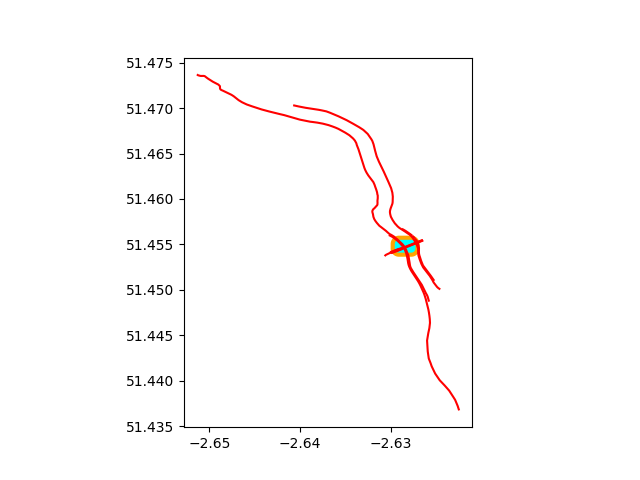

,geometry,osm_id,code,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel,type
124,"LINESTRING (-2.62890 51.45450, -2.62647 51.45547)",3578235,5114.0,secondary,Clifton Suspension Bridge,B3129,B,32.0,1.0,T,F,NaN
184,"LINESTRING (-2.62698 51.45493, -2.62696 51.454...",4002665,5112.0,trunk,Hotwell Road,A4,B,64.0,0.0,F,F,NaN
185,"LINESTRING (-2.62738 51.45566, -2.62713 51.455...",4002666,5112.0,trunk,Avon Gorge Gallery,A4,B,64.0,0.0,F,T,NaN
7426,"LINESTRING (-2.62886 51.45456, -2.62652 51.45549)",84470379,5153.0,footway,None,None,B,0.0,1.0,T,F,NaN
10103,"LINESTRING (-2.62766 51.45594, -2.62750 51.455...",133638236,5112.0,trunk,Hotwell Road,A4,B,64.0,0.0,F,F,NaN
10105,"LINESTRING (-2.62880 51.45672, -2.62841 51.456...",133638239,5112.0,trunk,Hotwell Road,A4,B,64.0,0.0,F,F,NaN
10222,"LINESTRING (-2.64078 51.47032, -2.64018 51.470...",144776655,5152.0,cycleway,Portway,None,B,0.0,0.0,F,F,NaN
10964,"LINESTRING (-2.63070 51.45370, -2.63064 51.453...",158410884,5114.0,secondary,None,B3129,B,32.0,0.0,F,F,NaN
13857,"LINESTRING (-2.65137 51.47371, -2.65125 51.473...",232628450,5152.0,cycleway,None,None,B,0.0,0.0,F,F,NaN
16597,"LINESTRING (-2.62905 51.45444, -2.62903 51.45445)",377184272,5114.0,secondary,None,B3129,B,32.0,0.0,F,F,NaN


In [9]:
this_layer = urban

hazards = hazards.append(this_layer[this_layer.geometry.intersects(hazard_poly)], sort=False)

ax=hazard_region.plot(color='orange')
flight_region.plot(ax=ax,color='cyan')
hazards.plot(ax=ax,color='red')
hazards

For tidiness, we crop the hazards to consider only those parts within the enlarged flight region `hazard_poly`.  Anything outside is more than 50m from where we're going to fly, so we can ignore it.

<IPython.core.display.Javascript object>


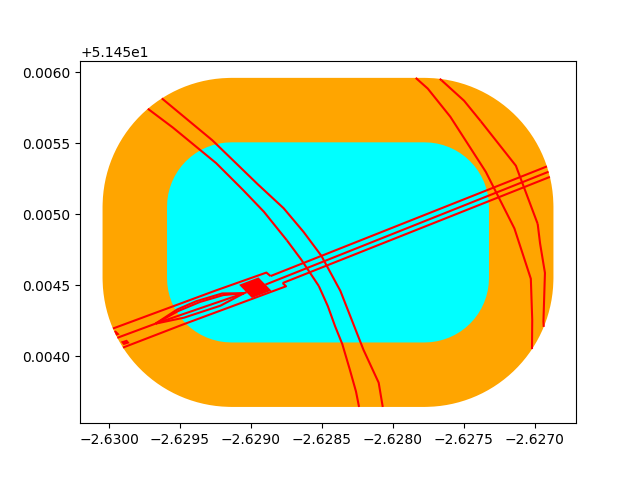

,geometry,osm_id,code,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel,type
124,"LINESTRING (-2.62890 51.45450, -2.62690 51.45530)",3578235,5114.0,secondary,Clifton Suspension Bridge,B3129,B,32.0,1.0,T,F,NaN
184,"LINESTRING (-2.62698 51.45493, -2.62696 51.454...",4002665,5112.0,trunk,Hotwell Road,A4,B,64.0,0.0,F,F,NaN
185,"LINESTRING (-2.62738 51.45566, -2.62713 51.455...",4002666,5112.0,trunk,Avon Gorge Gallery,A4,B,64.0,0.0,F,T,NaN
7426,"LINESTRING (-2.62886 51.45456, -2.62691 51.45534)",84470379,5153.0,footway,None,None,B,0.0,1.0,T,F,NaN
10103,"LINESTRING (-2.62766 51.45594, -2.62750 51.455...",133638236,5112.0,trunk,Hotwell Road,A4,B,64.0,0.0,F,F,NaN
10105,"LINESTRING (-2.62767 51.45596, -2.62766 51.45594)",133638239,5112.0,trunk,Hotwell Road,A4,B,64.0,0.0,F,F,NaN
10222,"LINESTRING (-2.62784 51.45596, -2.62775 51.455...",144776655,5152.0,cycleway,Portway,None,B,0.0,0.0,F,F,NaN
10964,"LINESTRING (-2.62994 51.45413, -2.62992 51.454...",158410884,5114.0,secondary,None,B3129,B,32.0,0.0,F,F,NaN
13857,"LINESTRING (-2.62963 51.45582, -2.62927 51.455...",232628450,5152.0,cycleway,None,None,B,0.0,0.0,F,F,NaN
16597,"LINESTRING (-2.62905 51.45444, -2.62903 51.45445)",377184272,5114.0,secondary,None,B3129,B,32.0,0.0,F,F,NaN


In [10]:
hazards = hazards.set_geometry(hazards.intersection(hazard_poly))

ax=hazard_region.plot(color='orange')
flight_region.plot(ax=ax,color='cyan')
hazards.plot(ax=ax,color='red')
hazards

Finally, we enlarge each hazard by the specified safety distance.  These are the places where we either cannot fly or need observers to confirm its clear to fly.  Those will be separated later.

<IPython.core.display.Javascript object>


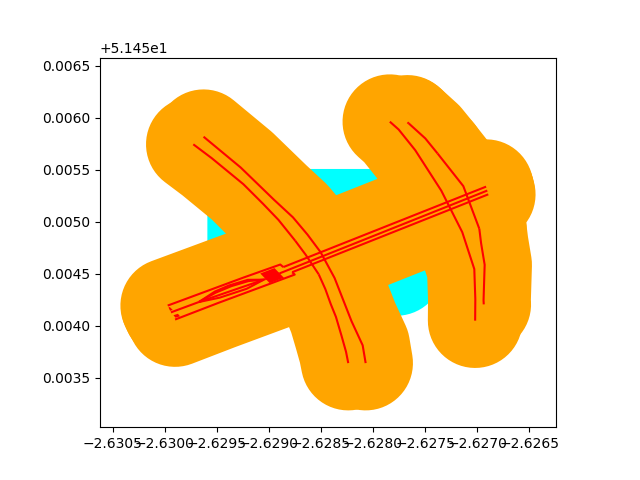

,geometry,osm_id,code,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel,type
124,"POLYGON ((-2.62707 51.45572, -2.62703 51.45574...",3578235,5114.0,secondary,Clifton Suspension Bridge,B3129,B,32.0,1.0,T,F,NaN
184,"POLYGON ((-2.62651 51.45486, -2.62648 51.45466...",4002665,5112.0,trunk,Hotwell Road,A4,B,64.0,0.0,F,F,NaN
185,"POLYGON ((-2.62678 51.45562, -2.62675 51.45559...",4002666,5112.0,trunk,Avon Gorge Gallery,A4,B,64.0,0.0,F,T,NaN
7426,"POLYGON ((-2.62708 51.45576, -2.62704 51.45577...",84470379,5153.0,footway,None,None,B,0.0,1.0,T,F,NaN
10103,"POLYGON ((-2.62719 51.45614, -2.62717 51.45611...",133638236,5112.0,trunk,Hotwell Road,A4,B,64.0,0.0,F,F,NaN
10105,"POLYGON ((-2.62737 51.45630, -2.62734 51.45627...",133638239,5112.0,trunk,Hotwell Road,A4,B,64.0,0.0,F,F,NaN
10222,"POLYGON ((-2.62745 51.45623, -2.62742 51.45620...",144776655,5152.0,cycleway,Portway,None,B,0.0,0.0,F,F,NaN
10964,"POLYGON ((-2.63009 51.45456, -2.63008 51.45456...",158410884,5114.0,secondary,None,B3129,B,32.0,0.0,F,F,NaN
13857,"POLYGON ((-2.62898 51.45587, -2.62896 51.45585...",232628450,5152.0,cycleway,None,None,B,0.0,0.0,F,F,NaN
16597,"POLYGON ((-2.62920 51.45487, -2.62915 51.45489...",377184272,5114.0,secondary,None,B3129,B,32.0,0.0,F,F,NaN


In [11]:
hazard_buffers = hazards.set_geometry(hazards.buffer(buffer_radius))

ax=flight_region.plot(color='cyan')
hazard_buffers.plot(ax=ax,color='orange')
hazards.plot(ax=ax,color='red')

hazard_buffers

## Safety zone

The all-important safety zone is where we can hover at any time, even if all of our hazards are active.  It's found by removing the hazard buffer regions from the flight region and seeing what's left.

<IPython.core.display.Javascript object>


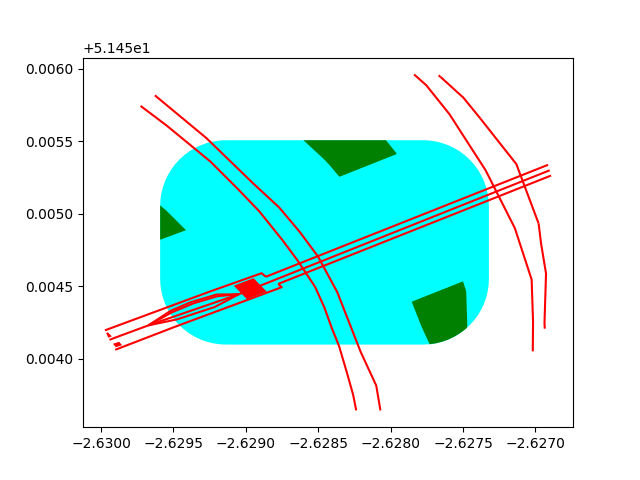

In [12]:
safe_region = flight_region[:]
for index,row in hazard_buffers.iterrows():
    safe_region = safe_region.set_geometry(safe_region.difference(row['geometry']))

ax=flight_region.plot(color='cyan')
hazards.plot(ax=ax,color='red')
safe_region.plot(ax=ax,color='green')

We must check if a safety region was found - if every part of the flight region is within 50m of a hazard, the safe region can come up empty.  If this happens, go back and enlarge the flight region and try again.

In [13]:
assert sum(safe_region.area)>0, "No safe region found.  Try enlarging the flight region"
print('Success! A safe region has been found with area {}.'.format(sum(safe_region.area)))
safe_region

Success! A safe region has been found with area 2.2800991550749254e-07.


,geometry
0,"MULTIPOLYGON (((-2.62959 51.45482, -2.62959 51..."


## No-fly zones

Recall that the hazards come in two types: those we can observe, _e.g._ a minor road or footpath, and those that are assumed always active, _e.g._ a major road.  Regions close to active hazards are no-fly zones - places we can never fly.  Regions outside no-fly zones but close to the remaining hazards are termed _control zones_ - places we can fly if we've checked the hazard is clear.  Next up we separate the two.

In this example, the no-fly zones are around the major road, so we extract them using the helpful `fclass` column in the data frame, in which value `trunk` signifies a major road.

In [14]:
(hazards.fclass=='trunk')

124      False
184       True
185       True
7426     False
10103     True
10105     True
10222    False
10964    False
13857    False
16597    False
16598    False
16599    False
16600    False
16610    False
16613    False
16614    False
16710    False
258      False
266      False
267      False
18988    False
18989    False
19672    False
Name: fclass, dtype: bool

<IPython.core.display.Javascript object>


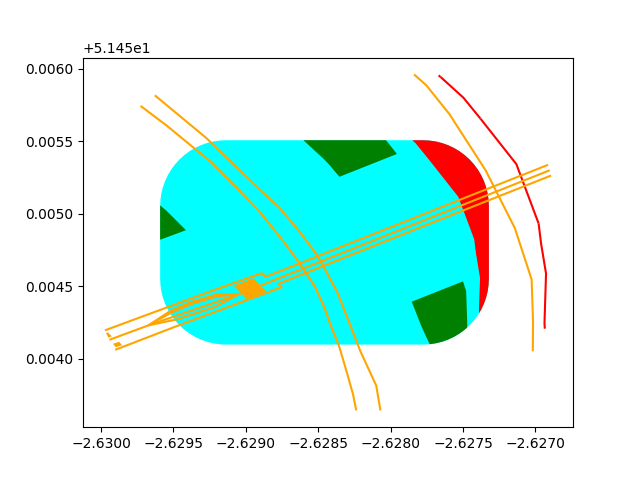

,geometry,osm_id,code,name,ref,oneway,maxspeed,layer,bridge,tunnel,type
fclass,,,,,,,,,,,
trunk,"POLYGON ((-2.62739 51.45431, -2.62738 51.45456...",4002665,5112.0,Hotwell Road,A4,B,64.0,0.0,F,F,NaN


In [15]:
haz_uncontrolled = (hazards.fclass=='trunk')

no_fly_zones = hazard_buffers[haz_uncontrolled]
no_fly_zones = no_fly_zones.set_geometry(no_fly_zones.intersection(flight_poly))

no_fly_zones = no_fly_zones.dissolve(by='fclass')

ax=flight_region.plot(color='cyan')
hazards[haz_uncontrolled].plot(ax=ax,color='red')
hazards[haz_uncontrolled==False].plot(ax=ax,color='orange')
safe_region.plot(ax=ax,color='green')
no_fly_zones.plot(ax=ax,color='red')

no_fly_zones

So far we have a data frame with all the no fly zones in it.  To subtract this from the remaining zones, we need it as just one Polygon (or MultiPolygon).  This is a little clunky but performed with the `dissolve` command and a dummy field to group all the rows into one item.

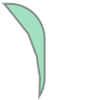

In [16]:
no_fly_zones['dissolve']=1
no_fly_poly = no_fly_zones.dissolve(by='dissolve').loc[1].geometry
no_fly_poly

## Control zones

The control zones are the remaining hazard buffers, clipped to catch only those parts overlapping with the flight region, and then with the no-fly zone removed.

> You could have multiple control zones, grouped according to the hazard type or identity.  I've found this makes a rather messy map at the end, so here they're dissolved just into the one polygon. 

<IPython.core.display.Javascript object>


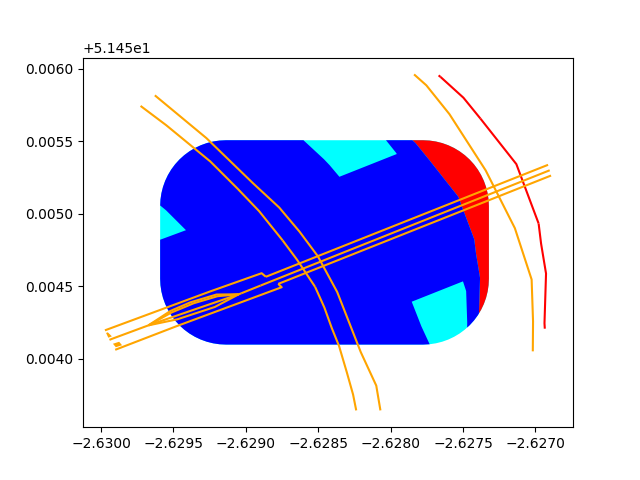

,geometry,osm_id,code,name,ref,oneway,maxspeed,layer,bridge,tunnel,type
dissolve,,,,,,,,,,,
1,"POLYGON ((-2.62859 51.45410, -2.62860 51.45410...",377184302,1500.0,None,None,B,0.0,0.0,F,F,NaN


In [17]:
control_zones = hazard_buffers[haz_uncontrolled==False].set_geometry(hazard_buffers[haz_uncontrolled==False].intersection(flight_poly))
control_zones = control_zones.set_geometry(control_zones.difference(no_fly_poly))
control_zones = control_zones.dissolve(by='fclass')

# dissolve into just one region - tidier map
control_zones['dissolve']=1
control_zones = control_zones.dissolve(by='dissolve')

ax=flight_region.plot(color='cyan')
hazards[haz_uncontrolled].plot(ax=ax,color='red')
hazards[haz_uncontrolled==False].plot(ax=ax,color='orange')
#safe_region.plot(ax=ax,color='green')
no_fly_zones.plot(ax=ax,color='red')
control_zones.plot(ax=ax,color='blue')

control_zones

## Point SAFTI

With the different flight zones, identified we get back to the waypoints, and adding some key ones into our flight.  The SAFTI point will be our refuge if we need it, being the closest point to the first waypoint that's in the safety zone.  It gets added twice, as the flight will start and end with a trip to SAFTI.

<IPython.core.display.Javascript object>


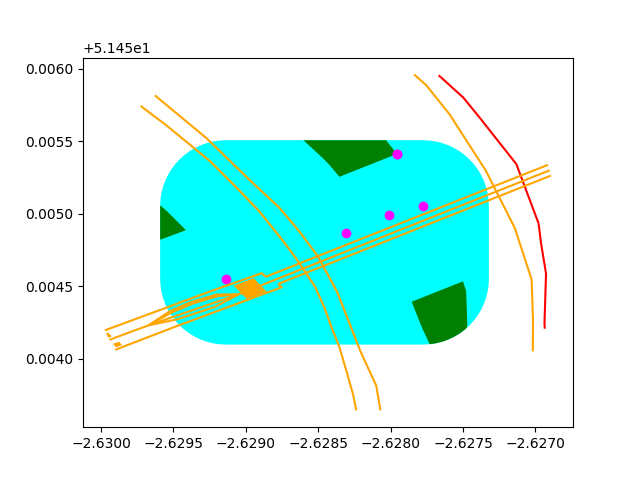

In [18]:
from shapely.ops import nearest_points
start_point,safti_point = nearest_points(wypts.loc[1,'geometry'], safe_region.loc[0,'geometry'])
safti_idx = len(wypts)
wypts.loc[safti_idx, 'geometry'] = safti_point
wypts.loc[safti_idx, 'Name'] = 'SAFTI'

safti_idx_2 = len(wypts)
wypts.loc[safti_idx_2, 'geometry'] = safti_point
wypts.loc[safti_idx_2, 'Name'] = 'SAFTI'

ax=flight_region.plot(color='cyan')
hazards[haz_uncontrolled].plot(ax=ax,color='red')
hazards[haz_uncontrolled==False].plot(ax=ax,color='orange')
safe_region.plot(ax=ax,color='green')
wypts.plot(ax=ax,color='magenta')

## Approach points

Flights will always go to SAFTI before the first operational waypoint, as we need to check the hazards before approaching.  To verify that the approach is safe, _e.g._ that there are no unexpected obstructions that weren't on the map, two intermediate waypoints are added:
* TWENI: 20m from the first waypoint
* TENNA: 10m from the first waypoint

<IPython.core.display.Javascript object>


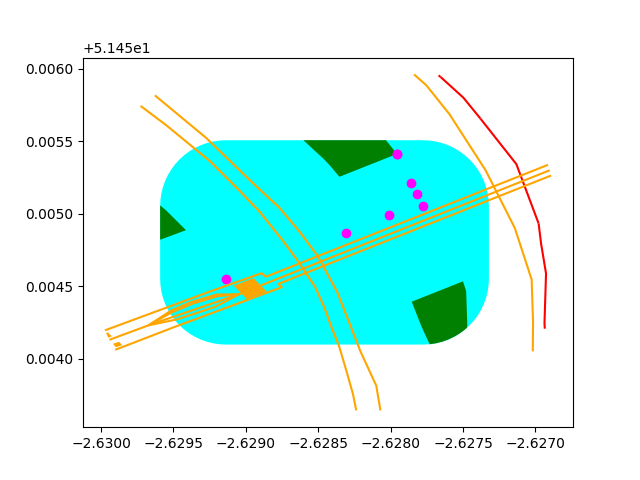

,geometry,Name
0,POINT (-2.62914 51.45455),HOMER
1,POINT (-2.62778 51.45505),ALPHA
2,POINT (-2.62801 51.45499),BRAVO
3,POINT (-2.62831 51.45487),CHALI
4,POINT (-2.62796 51.45541),SAFTI
5,POINT (-2.62796 51.45541),SAFTI
6,POINT (-2.62782 51.45513),TENNA
7,POINT (-2.62786 51.45522),TWENI


In [19]:
first_point = wypts.loc[1,'geometry']
dist_safti_first = safti_point.distance(first_point)
dx = safti_point.x - first_point.x
dy = safti_point.y - first_point.y

tenna_point = Point(first_point.x + 10.0*metres_to_deglatlon*dx/dist_safti_first,
                    first_point.y + 10.0*metres_to_deglatlon*dy/dist_safti_first)
tenna_idx = len(wypts)
wypts.loc[tenna_idx,'geometry']=tenna_point
wypts.loc[tenna_idx,'Name']='TENNA'

tweni_point = Point(first_point.x + 20.0*metres_to_deglatlon*dx/dist_safti_first,
                    first_point.y + 20.0*metres_to_deglatlon*dy/dist_safti_first)
tweni_idx = len(wypts)
wypts.loc[tweni_idx,'geometry']=tweni_point
wypts.loc[tweni_idx,'Name']='TWENI'

ax=flight_region.plot(color='cyan')
hazards[haz_uncontrolled].plot(ax=ax,color='red')
hazards[haz_uncontrolled==False].plot(ax=ax,color='orange')
safe_region.plot(ax=ax,color='green')
wypts.plot(ax=ax,color='magenta')

wypts

## Point TESTA

It's also useful to have a safe point near the home point, as somewhere quick to get to immediately after take-off.  Here, a lot of self-tests will be performed before continuing the flight, so we call this point TESTA.

<IPython.core.display.Javascript object>


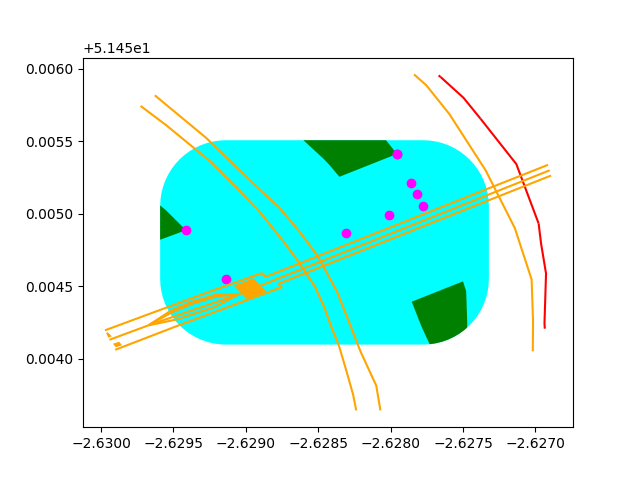

In [20]:
home_point,testa_point = nearest_points(wypts.loc[0,'geometry'], safe_region.loc[0,'geometry'])
testa_idx = len(wypts)
wypts.loc[testa_idx, 'geometry'] = testa_point
wypts.loc[testa_idx, 'Name'] = 'TESTA'

ax=flight_region.plot(color='cyan')
hazards[haz_uncontrolled].plot(ax=ax,color='red')
hazards[haz_uncontrolled==False].plot(ax=ax,color='orange')
safe_region.plot(ax=ax,color='green')
wypts.plot(ax=ax,color='magenta')

## Flight path

We've been adding waypoints in no particular order.  To get the ordering right, 100 is added to all the point indices to form a new `FlightOrder` field, and then the intermediate points HOMER, SAFTI, TWENI _etc._ are re-numbered to put them in the right place.

In [21]:
wypts['FlightOrder']=[ii+100 for ii in wypts.index]
wypts.loc[0,'FlightOrder']=0
wypts.loc[testa_idx,'FlightOrder']=1
wypts.loc[safti_idx,'FlightOrder']=2
wypts.loc[tweni_idx,'FlightOrder']=3
wypts.loc[tenna_idx,'FlightOrder']=4
wypts.loc[safti_idx_2,'FlightOrder']=999
wypts

,geometry,Name,FlightOrder
0,POINT (-2.62914 51.45455),HOMER,0
1,POINT (-2.62778 51.45505),ALPHA,101
2,POINT (-2.62801 51.45499),BRAVO,102
3,POINT (-2.62831 51.45487),CHALI,103
4,POINT (-2.62796 51.45541),SAFTI,2
5,POINT (-2.62796 51.45541),SAFTI,999
6,POINT (-2.62782 51.45513),TENNA,4
7,POINT (-2.62786 51.45522),TWENI,3
8,POINT (-2.62941 51.45489),TESTA,1


The `FlightOrder` column can be used to sort the waypoints.  Then the flight legs are created in the form of a data frame with a row for each adjacent pair of waypoints.

Leg from 0 to 8
LINESTRING (-2.629137 51.454551, -2.629413130846814 51.45488633173525)
Leg from 8 to 4
LINESTRING (-2.629413130846814 51.45488633173525, -2.627957303886802 51.45541236635319)
Leg from 4 to 7
LINESTRING (-2.627957303886802 51.45541236635319, -2.627857896707803 51.45521532923486)
Leg from 7 to 6
LINESTRING (-2.627857896707803 51.45521532923486, -2.627816948353902 51.45513416461743)
Leg from 6 to 1
LINESTRING (-2.627816948353902 51.45513416461743, -2.627776 51.455053)
Leg from 1 to 2
LINESTRING (-2.627776 51.455053, -2.62801 51.45499)
Leg from 2 to 3
LINESTRING (-2.62801 51.45499, -2.628306 51.45487)
Leg from 3 to 5
LINESTRING (-2.628306 51.45487, -2.627957303886802 51.45541236635319)
Leg from 5 to 0
LINESTRING (-2.627957303886802 51.45541236635319, -2.629137 51.454551)


<IPython.core.display.Javascript object>


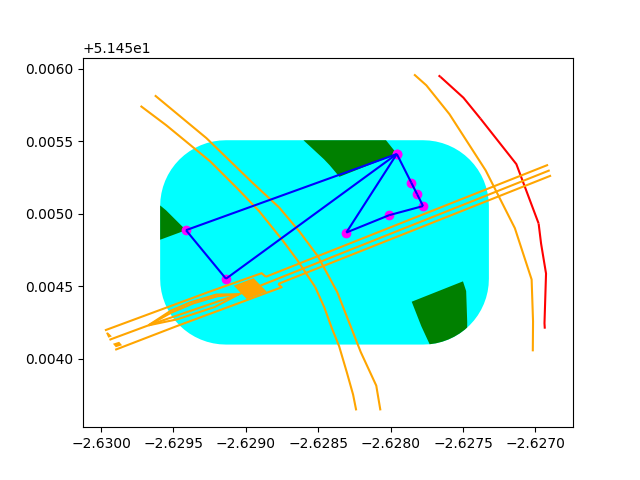

,geometry
0,"LINESTRING (-2.62914 51.45455, -2.62941 51.45489)"
1,"LINESTRING (-2.62941 51.45489, -2.62796 51.45541)"
2,"LINESTRING (-2.62796 51.45541, -2.62786 51.45522)"
3,"LINESTRING (-2.62786 51.45522, -2.62782 51.45513)"
4,"LINESTRING (-2.62782 51.45513, -2.62778 51.45505)"
5,"LINESTRING (-2.62778 51.45505, -2.62801 51.45499)"
6,"LINESTRING (-2.62801 51.45499, -2.62831 51.45487)"
7,"LINESTRING (-2.62831 51.45487, -2.62796 51.45541)"
8,"LINESTRING (-2.62796 51.45541, -2.62914 51.45455)"


In [22]:
sorted_wypts = wypts.sort_values(by='FlightOrder')
sorted_indices = sorted_wypts.index
num_wypts = len(sorted_indices)

from shapely.geometry import LineString
flight_leg_list = []
for ii in range(num_wypts):
    next_ii = (ii+1)%num_wypts
    start_point=wypts.loc[sorted_indices[ii],'geometry']
    end_point=wypts.loc[sorted_indices[next_ii],'geometry']
    print('Leg from {} to {}'.format(sorted_indices[ii],sorted_indices[next_ii]))
    geom = LineString([[start_point.x,start_point.y],[end_point.x,end_point.y]])
    print(geom)
    flight_leg_list.append(geom)
flight_legs = gpd.GeoDataFrame(geometry=flight_leg_list)

ax=flight_region.plot(color='cyan')
hazards[haz_uncontrolled].plot(ax=ax,color='red')
hazards[haz_uncontrolled==False].plot(ax=ax,color='orange')
safe_region.plot(ax=ax,color='green')
flight_legs.plot(ax=ax,color='blue')
wypts.plot(ax=ax,color='magenta')

flight_legs

## Save data in GIS format

For visualizing in a GIS programme, _i.e._ drawing a much prettier map, save the data files to a folder.  These files can be opened in QGIS or similar, overlaid on a base raster map, formatted beautifully, labeled, _etc._

In [26]:
from os import mkdir
output_dir = 'bristol_example_osm'
try:
    mkdir(output_dir)
except FileExistsError:
    pass

In [27]:
flight_region.to_file(output_dir+'/flight_region.shp')
no_fly_zones.to_file(output_dir+'/no_fly_zones.shp')
control_zones.to_file(output_dir+'/control_zones.shp')
sorted_wypts.to_file(output_dir+'/waypoints.shp')
flight_legs.to_file(output_dir+'/flight_legs.shp')

Here's the same data viewed in QGIS.

![map](bristol_example_osm/qgis_map.png)

Finally, we can write these to a MAVLINK mission file using utilities provided in the pymavlink library.

In [28]:
from pymavlink.mavwp import MAVWPLoader
wp = MAVWPLoader()

for ii,row in sorted_wypts.iterrows():
    wp.add_latlonalt(row['geometry'].y,row['geometry'].x,0.0)
    
file_name = output_dir+'/mission.txt'
wp.save(file_name)

%cat bristol_example_osm/mission.txt

QGC WPL 110
0	0	3	16	0.000000	0.000000	0.000000	0.000000	51.454551	-2.629137	0.000000	0
1	0	3	16	0.000000	0.000000	0.000000	0.000000	51.454886	-2.629413	0.000000	0
2	0	3	16	0.000000	0.000000	0.000000	0.000000	51.455412	-2.627957	0.000000	0
3	0	3	16	0.000000	0.000000	0.000000	0.000000	51.455215	-2.627858	0.000000	0
4	0	3	16	0.000000	0.000000	0.000000	0.000000	51.455134	-2.627817	0.000000	0
5	0	3	16	0.000000	0.000000	0.000000	0.000000	51.455053	-2.627776	0.000000	0
6	0	3	16	0.000000	0.000000	0.000000	0.000000	51.454990	-2.628010	0.000000	0
7	0	3	16	0.000000	0.000000	0.000000	0.000000	51.454870	-2.628306	0.000000	0
8	0	3	16	0.000000	0.000000	0.000000	0.000000	51.455412	-2.627957	0.000000	0


### To Do

* Insert speed management mission items
* Include altitude
* Insert delays and heading constraints
* Automate behaviour tree generation!